In [15]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

## Data Organization

In [16]:
base_path = Path.cwd() / "derived"

sales_data = pd.read_excel(base_path / "Dailysales.xlsx")
precipitation_data = pd.read_excel(base_path / "Precip.xlsx")
consfoot_data = pd.read_excel(base_path / "ConsumerFootTraffic.xlsx")

sales_data['Date'] = pd.to_datetime(sales_data['Date'])
precipitation_data['Date'] = pd.to_datetime(precipitation_data['Date'])
consfoot_data['Date'] = pd.to_datetime(consfoot_data['Date'])

merged_data = sales_data.merge(precipitation_data, on='Date', how='left')
merged_data = merged_data.merge(consfoot_data, on='Date', how='left')

merged_data.to_csv(base_path / "merged_data.csv", index=False)

Adding weekend flag variable and outputting the merged data

In [17]:
# Creating 'IsWeekend' boolean column:
merged_data['IsWeekend'] = merged_data['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)
merged_data['DayOfWeek'] = merged_data['DayOfWeek'].astype('category')

print("First few rows of merged_data:")
print(merged_data.head())
print("\nColumns in merged_data:")
print(merged_data.columns.tolist())

First few rows of merged_data:
        Date  TotalSales  DayOfWeek  Precipitation  Unique  IsWeekend
0 2023-01-01           3     Sunday              1       2          1
1 2023-01-02           8     Monday              1       7          0
2 2023-01-03          19    Tuesday              1      19          0
3 2023-01-04           4  Wednesday              1       4          0
4 2023-01-05           7   Thursday              1       6          0

Columns in merged_data:
['Date', 'TotalSales', 'DayOfWeek', 'Precipitation', 'Unique', 'IsWeekend']


# Performing Analysis

## Initial Ordinary Least Squares (OLS) Regression Analysis

In [18]:
# 1. OLS model to compare weekday sales with weekend sales
weekend_model = smf.ols('TotalSales ~ IsWeekend', data=merged_data).fit()
print("Weekend Model Summary:")
print(weekend_model.summary())
print("\n" + "="*50 + "\n")

# 2. OLS model with DayOfWeek
ols_model_dow = smf.ols('TotalSales ~ DayOfWeek', data=merged_data).fit()
print("Day of Week Model Summary:")
print(ols_model_dow.summary())
print("\n" + "="*50 + "\n")

Weekend Model Summary:
                            OLS Regression Results                            
Dep. Variable:             TotalSales   R-squared:                       0.184
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     81.98
Date:                Sat, 29 Nov 2025   Prob (F-statistic):           8.57e-18
Time:                        01:14:20   Log-Likelihood:                -1408.9
No. Observations:                 365   AIC:                             2822.
Df Residuals:                     363   BIC:                             2830.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9346      0.

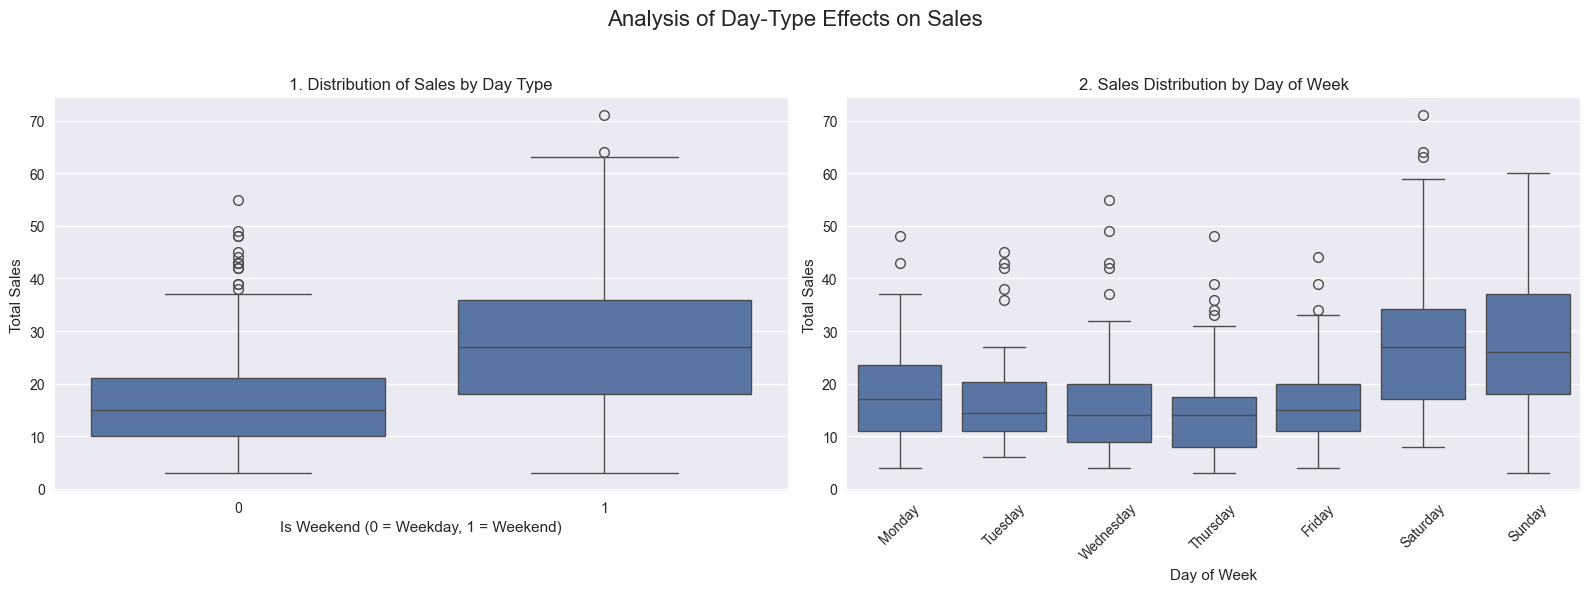

In [19]:
plt.style.use('seaborn-v0_8')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analysis of Day-Type Effects on Sales', fontsize=16)

# Ploting Distribution by weekday vs. weekend
sns.boxplot(data=merged_data, x='IsWeekend', y='TotalSales', ax=axes[0])
axes[0].set_xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
axes[0].set_ylabel('Total Sales')
axes[0].set_title('1. Distribution of Sales by Day Type')

# Plotting Sales by Day of Week
sns.boxplot(data=merged_data, x='DayOfWeek', y='TotalSales', ax=axes[1], 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Total Sales')
axes[1].set_title('2. Sales Distribution by Day of Week')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()